In [1]:
import jax
from random_events.set import SetElement

include_variables = 20

class Digit(SetElement):
    EMPTY_SET = -1
    ZERO = 0
    ONE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9

In [2]:
from sortedcontainers import SortedSet
from random_events.variable import Symbolic, Continuous

variables = SortedSet([Symbolic("Digit", Digit)] + [Continuous(f"Pixel_{i}_{j}") for i in range(8) for j in range(8)])
variables = variables[:include_variables]

In [3]:
from sklearn import datasets
import numpy as np
from sklearn.preprocessing import MinMaxScaler
digits = datasets.load_digits(as_frame=False)
x = digits.data
y = digits.target
data = np.concatenate((y.reshape(-1, 1), x), axis=1)[:, :include_variables]
data[:, 1:] = MinMaxScaler((-1, 1)).fit_transform(data[:, 1:])

In [4]:
from probabilistic_model.learning.region_graph.region_graph import RegionGraph

region_graph = RegionGraph(variables, repetitions=6, depth=3, partitions=2)
region_graph = region_graph.create_random_region_graph()
model = region_graph.as_probabilistic_circuit(input_units=16, sum_units=5)

C:\Users\tomsc\probabilistic_model\src\probabilistic_model\learning\region_graph\region_graph.py:132: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  node.layer = GaussianLayer(variable_index, location=location, log_scale=log_scale, min_scale=jnp.full_like(location, 0.01))
C:\Users\tomsc\probabilistic_model\src\probabilistic_model\learning\region_graph\region_graph.py:132: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  node.layer = GaussianLayer(variable_index, location=location, log_scale=log_scale, min_scale=jnp.full_like(location, 0.01))
C:\Users\tomsc\probabilistic_model\src\probabilistic_model\learning\region_graph\region_graph.py:139: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  node.layer = DiscreteLayer(variable_index, log_probabilities=log_probabilities)


Converting to nx: 100%|██████████| 9030/9030 [00:03<00:00, 2790.59it/s, Creating Gaussian distributions for variable Pixel_1_5]                                                                                                                                                                                                                                                                                                                                                                                                                                                   


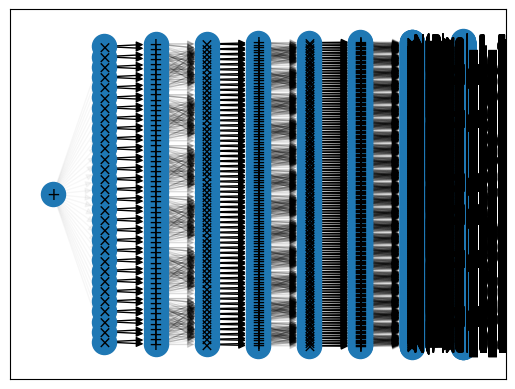

In [5]:
from matplotlib import pyplot as plt

nx_model = model.to_nx()
nx_model.plot_structure()
plt.show()

In [6]:
print(model.root.number_of_trainable_parameters)

8514


In [7]:
import optax
import equinox as eqx
import jax.numpy as jnp
import tqdm

root = model.root

@eqx.filter_jit
def loss(p, x):
    ll = p.log_likelihood_of_nodes(x)
    return -jnp.mean(ll)

optimizer = optax.adamw(0.01)
opt_state = optimizer.init(eqx.filter(root, eqx.is_inexact_array))

for _ in tqdm.trange(100):
    loss_value, grads = eqx.filter_value_and_grad(loss)(root, data)

    updates, opt_state = optimizer.update(
        grads, opt_state, eqx.filter(root, eqx.is_inexact_array)
    )
    root = eqx.apply_updates(root, updates)
    print(loss_value)

  1%|          | 1/100 [04:09<6:52:11, 249.81s/it]

29.758034


  2%|▏         | 2/100 [04:10<2:48:36, 103.23s/it]

29.491854


  3%|▎         | 3/100 [04:11<1:31:09, 56.39s/it] 

29.22579


  4%|▍         | 4/100 [04:11<54:58, 34.36s/it]  

28.959911


  5%|▌         | 5/100 [04:12<35:23, 22.35s/it]

28.694275


  6%|▌         | 6/100 [04:13<23:26, 14.97s/it]

28.428932


  7%|▋         | 7/100 [04:13<15:55, 10.27s/it]

28.16395


  8%|▊         | 8/100 [04:14<11:01,  7.19s/it]

27.89941


  9%|▉         | 9/100 [04:15<07:46,  5.13s/it]

27.635372


 10%|█         | 10/100 [04:15<05:35,  3.73s/it]

27.371897


 11%|█         | 11/100 [04:16<04:08,  2.79s/it]

27.109041


 12%|█▏        | 12/100 [04:16<03:06,  2.12s/it]

26.846851


 13%|█▎        | 13/100 [04:18<02:36,  1.80s/it]

26.585342


 14%|█▍        | 14/100 [04:18<02:02,  1.43s/it]

26.324512


 15%|█▌        | 15/100 [04:19<01:39,  1.17s/it]

26.064316


 16%|█▌        | 16/100 [04:19<01:23,  1.01it/s]

25.804663


 17%|█▋        | 17/100 [04:20<01:13,  1.12it/s]

25.545406


 18%|█▊        | 18/100 [04:21<01:06,  1.23it/s]

25.286333


 19%|█▉        | 19/100 [04:21<01:00,  1.34it/s]

25.027166


 20%|██        | 20/100 [04:22<01:06,  1.21it/s]

24.767565


 21%|██        | 21/100 [04:23<00:59,  1.33it/s]

24.507141


 22%|██▏       | 22/100 [04:23<00:54,  1.42it/s]

24.245478


 23%|██▎       | 23/100 [04:24<00:51,  1.48it/s]

23.982162


 24%|██▍       | 24/100 [04:25<00:49,  1.54it/s]

23.716803


 25%|██▌       | 25/100 [04:25<00:48,  1.54it/s]

23.449053


 26%|██▌       | 26/100 [04:26<00:47,  1.57it/s]

23.178593


 27%|██▋       | 27/100 [04:26<00:45,  1.59it/s]

22.90518


 28%|██▊       | 28/100 [04:27<00:54,  1.33it/s]

22.628626


 29%|██▉       | 29/100 [04:28<00:49,  1.42it/s]

22.348824


 30%|███       | 30/100 [04:29<00:48,  1.45it/s]

22.065748


 31%|███       | 31/100 [04:29<00:45,  1.51it/s]

21.779457


 32%|███▏      | 32/100 [04:30<00:43,  1.55it/s]

21.490086


 33%|███▎      | 33/100 [04:31<00:42,  1.57it/s]

21.197838


 34%|███▍      | 34/100 [04:31<00:41,  1.61it/s]

20.902956


 35%|███▌      | 35/100 [04:32<00:48,  1.35it/s]

20.60573


 36%|███▌      | 36/100 [04:33<00:45,  1.40it/s]

20.30645


 37%|███▋      | 37/100 [04:33<00:42,  1.47it/s]

20.005413


 38%|███▊      | 38/100 [04:34<00:41,  1.51it/s]

19.702919


 39%|███▉      | 39/100 [04:35<00:39,  1.56it/s]

19.39927


 40%|████      | 40/100 [04:35<00:37,  1.60it/s]

19.094746


 41%|████      | 41/100 [04:36<00:36,  1.60it/s]

18.789616


 42%|████▏     | 42/100 [04:36<00:35,  1.62it/s]

18.48411


 43%|████▎     | 43/100 [04:37<00:43,  1.32it/s]

18.178427


 44%|████▍     | 44/100 [04:38<00:40,  1.38it/s]

17.872711


 45%|████▌     | 45/100 [04:39<00:39,  1.38it/s]

17.56707


 46%|████▌     | 46/100 [04:40<00:38,  1.39it/s]

17.261555


 47%|████▋     | 47/100 [04:40<00:37,  1.41it/s]

16.9562


 48%|████▊     | 48/100 [04:41<00:35,  1.48it/s]

16.651018


 49%|████▉     | 49/100 [04:41<00:34,  1.50it/s]

16.34602


 50%|█████     | 50/100 [04:43<00:40,  1.24it/s]

16.041248


 51%|█████     | 51/100 [04:43<00:36,  1.33it/s]

15.736765


 52%|█████▏    | 52/100 [04:44<00:33,  1.42it/s]

15.432679


 53%|█████▎    | 53/100 [04:44<00:31,  1.48it/s]

15.12912


 54%|█████▍    | 54/100 [04:45<00:29,  1.54it/s]

14.82623


 55%|█████▌    | 55/100 [04:46<00:28,  1.56it/s]

14.524127


 56%|█████▌    | 56/100 [04:46<00:27,  1.58it/s]

14.222909


 57%|█████▋    | 57/100 [04:47<00:26,  1.64it/s]

13.922631


 58%|█████▊    | 58/100 [04:48<00:30,  1.36it/s]

13.623316


 59%|█████▉    | 59/100 [04:48<00:29,  1.41it/s]

13.324957


 60%|██████    | 60/100 [04:49<00:26,  1.50it/s]

13.027511


 61%|██████    | 61/100 [04:50<00:25,  1.56it/s]

12.73091


 62%|██████▏   | 62/100 [04:50<00:24,  1.58it/s]

12.435058


 63%|██████▎   | 63/100 [04:51<00:23,  1.60it/s]

12.139805


 64%|██████▍   | 64/100 [04:51<00:22,  1.59it/s]

11.844976


 65%|██████▌   | 65/100 [04:53<00:26,  1.34it/s]

11.550361


 66%|██████▌   | 66/100 [04:53<00:23,  1.43it/s]

11.2557335


 67%|██████▋   | 67/100 [04:54<00:22,  1.47it/s]

10.9608555


 68%|██████▊   | 68/100 [04:54<00:20,  1.54it/s]

10.665478


 69%|██████▉   | 69/100 [04:55<00:19,  1.56it/s]

10.369335


 70%|███████   | 70/100 [04:56<00:18,  1.60it/s]

10.072151


 71%|███████   | 71/100 [04:56<00:17,  1.61it/s]

9.773654


 72%|███████▏  | 72/100 [04:57<00:17,  1.63it/s]

9.473597


 73%|███████▎  | 73/100 [04:58<00:20,  1.30it/s]

9.171737


 74%|███████▍  | 74/100 [04:59<00:19,  1.35it/s]

8.867825


 75%|███████▌  | 75/100 [04:59<00:17,  1.44it/s]

8.5615635


 76%|███████▌  | 76/100 [05:00<00:16,  1.49it/s]

8.252598


 77%|███████▋  | 77/100 [05:00<00:15,  1.52it/s]

7.940495


 78%|███████▊  | 78/100 [05:01<00:14,  1.56it/s]

7.6247325


 79%|███████▉  | 79/100 [05:02<00:13,  1.60it/s]

7.3046813


 80%|████████  | 80/100 [05:03<00:15,  1.32it/s]

6.9796343


 81%|████████  | 81/100 [05:03<00:13,  1.39it/s]

6.6489096


 82%|████████▏ | 82/100 [05:04<00:12,  1.48it/s]

6.312021


 83%|████████▎ | 83/100 [05:04<00:11,  1.49it/s]

5.9688225


 84%|████████▍ | 84/100 [05:05<00:10,  1.56it/s]

5.619798


 85%|████████▌ | 85/100 [05:06<00:09,  1.59it/s]

5.2660804


 86%|████████▌ | 86/100 [05:06<00:08,  1.60it/s]

4.9091535


 87%|████████▋ | 87/100 [05:07<00:08,  1.62it/s]

4.550606


 88%|████████▊ | 88/100 [05:08<00:09,  1.33it/s]

4.191816


 89%|████████▉ | 89/100 [05:09<00:07,  1.40it/s]

3.8339455


 90%|█████████ | 90/100 [05:09<00:06,  1.45it/s]

3.478217


 91%|█████████ | 91/100 [05:10<00:05,  1.51it/s]

3.1258914


 92%|█████████▏| 92/100 [05:10<00:05,  1.52it/s]

2.777955


 93%|█████████▎| 93/100 [05:11<00:04,  1.55it/s]

2.4348807


 94%|█████████▍| 94/100 [05:12<00:03,  1.58it/s]

2.0967867


 95%|█████████▌| 95/100 [05:13<00:03,  1.32it/s]

1.7637181


 96%|█████████▌| 96/100 [05:13<00:02,  1.42it/s]

1.4356644


 97%|█████████▋| 97/100 [05:14<00:02,  1.48it/s]

1.1124218


 98%|█████████▊| 98/100 [05:15<00:01,  1.52it/s]

0.79358286


 99%|█████████▉| 99/100 [05:15<00:00,  1.57it/s]

0.4789208


100%|██████████| 100/100 [05:16<00:00,  3.16s/it]

0.16863488
